# Dynamics via acceleration maps

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from analysis import analysis

mu_factor = 6   # mu
min_factor = 8  # min

#### Load

In [79]:
global_pos = pd.read_pickle("data/raw_D0.1_Req5.5.pkl")
global_pos.rename(columns={"grid id" : "gid", "run id" : "rid"}, inplace=True)
print(global_pos.D.unique(), global_pos.R_eq.unique())

global_pos.x *= mu_factor
global_pos.y *= mu_factor

global_pos

[0.1] [5.5]


,x,y,D,R_eq,gid,rid
0,75.000000,150.000000,0.1,5.5,141,45
1,74.237652,151.125929,0.1,5.5,141,45
2,75.373087,151.068514,0.1,5.5,141,45
3,76.777830,151.082188,0.1,5.5,141,45
4,78.177747,151.154079,0.1,5.5,141,45
...,...,...,...,...,...,...
395,158.369584,150.273492,0.1,5.5,131,9
396,159.056770,150.216794,0.1,5.5,131,9
397,158.089067,150.162866,0.1,5.5,131,9
398,156.904382,150.136935,0.1,5.5,131,9


#### Position distribution

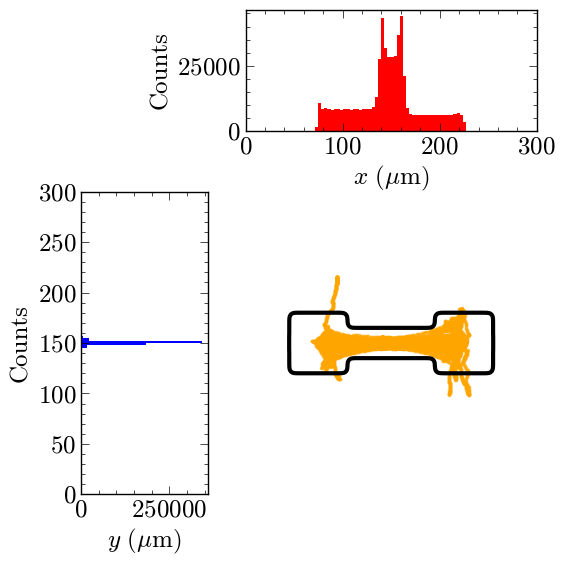

In [80]:
analysis.view_position_dist(global_pos, mu_factor)

# escaped_gids = global_pos.query("y > 170 or y < 130 or x > 250 or x < 50").gid.to_list()
# escaped_runs = global_pos.query("y > 170 or y < 130 or x > 250 or x < 50").rid.to_list()

# print(f"Eliminating {len(escaped_gids)} runs..")
# global_pos = global_pos.query("gid != @escaped_gids and rid != @escaped_runs")
# analysis.view_position_dist(global_pos, mu_factor)


### Hopping times

In [81]:
hop_times = []
for (gid, rid), df in global_pos.groupby(["gid", "rid"]):
        t = analysis.get_hopping_times(df, mu_factor, min_factor)
        [hop_times.append(el) for el in t]


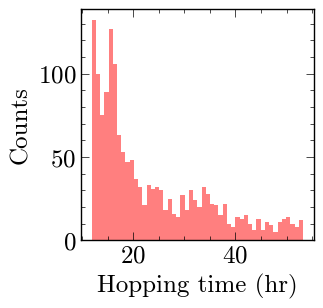

In [82]:
plt.figure(figsize=(3, 3))
plt.hist(np.array(hop_times)/60, bins=50, color="red", alpha=0.5)
plt.xlabel("Hopping time (hr)")
plt.ylabel("Counts")
plt.show()

### Acceleration maps

In [83]:
global_x_v_a = []

for (gid, rid), df in global_pos.groupby(["gid", "rid"]):
    x_v_a = analysis.calc_v_a_from_position(df.x, dt=0.002 * 500 * min_factor)
    x_v_a["gid"] = gid
    x_v_a["rid"] = rid
    global_x_v_a.append(x_v_a)

global_x_v_a = pd.concat(global_x_v_a)
global_x_v_a


,x,v,a,gid,rid
0,75.000000,0.113912,-0.014454,120,0
1,75.911300,-0.001721,0.022177,120,0
2,75.897532,0.175699,0.000194,120,0
3,77.303124,0.177248,0.000502,120,0
4,78.721107,0.181264,0.000061,120,0
...,...,...,...,...,...
393,162.032533,0.151839,0.000229,149,47
394,163.247246,0.153671,0.000560,149,47
395,164.476617,0.158148,0.000461,149,47
396,165.741799,0.161833,-0.000279,149,47


In [84]:
bounds = global_x_v_a.agg(["min", max])
xmin, xmax = bounds["x"]
vmin, vmax = bounds["v"]

nbins = 30
dx = (xmax - xmin) / nbins
dv = (vmax - vmin) / nbins

print(xmin, xmax)
print(vmin, vmax)

68.15918078132859 230.34963568736455
-0.1991666527554532 0.21180572411765475


In [85]:
x1 = ("x", xmin, dx)
x2 = ("v", vmin, dv)

analysis.get_bin_indices(global_x_v_a, nbins, x1, x2)
global_x_v_a

,x,v,a,gid,rid,x_bin,v_bin
0,75.000000,0.113912,-0.014454,120,0,1,22
1,75.911300,-0.001721,0.022177,120,0,1,14
2,75.897532,0.175699,0.000194,120,0,1,27
3,77.303124,0.177248,0.000502,120,0,1,27
4,78.721107,0.181264,0.000061,120,0,1,27
...,...,...,...,...,...,...,...
393,162.032533,0.151839,0.000229,149,47,17,25
394,163.247246,0.153671,0.000560,149,47,17,25
395,164.476617,0.158148,0.000461,149,47,17,26
396,165.741799,0.161833,-0.000279,149,47,18,26


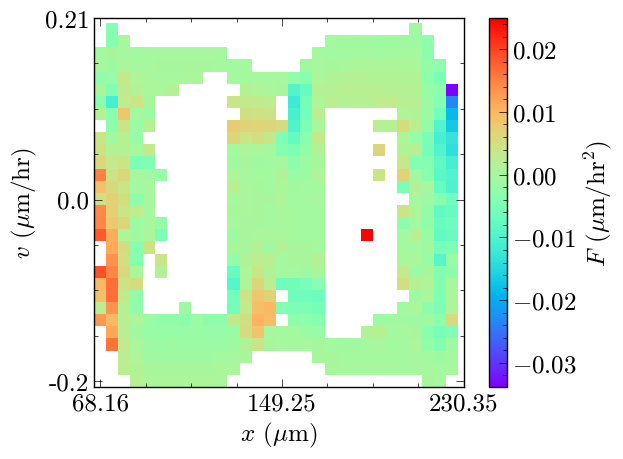

In [86]:
map_a = analysis.map_a(global_x_v_a, nbins, "x_bin", "v_bin")

from matplotlib.ticker import FormatStrFormatter

plt.imshow(map_a, origin="lower", interpolation="none", cmap="rainbow")
plt.xticks(
    [0, nbins // 2, nbins],
    [round(xmin, 2), round((xmin + xmax) / 2, 2), round(xmax, 2)],
)
plt.yticks(
    [0, nbins // 2, nbins], [round(vmin, 2), round((vmin + vmax) / 2, 0), round(vmax, 2)]
)
cbar = plt.colorbar()
cbar.set_label(r"$F$ ($\mu$m/hr$^2$)")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()


### Streamlines

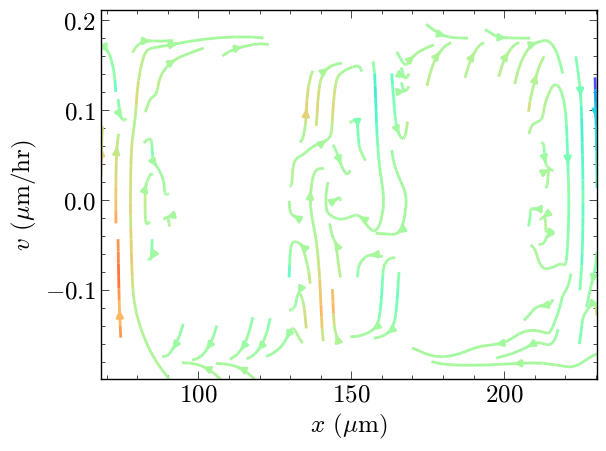

In [87]:
X, Y = np.meshgrid(np.linspace(xmin, xmax, nbins), np.linspace(vmin, vmax, nbins))

V = np.empty(X.shape)
V[:] = np.nan

for (j, i), df in global_x_v_a.groupby(["x_bin", "v_bin"]):
    a = df.a.mean()
    V[i, j] = a 

plt.streamplot(X, Y, Y, V, linewidth=2, color=V, cmap="rainbow")
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()

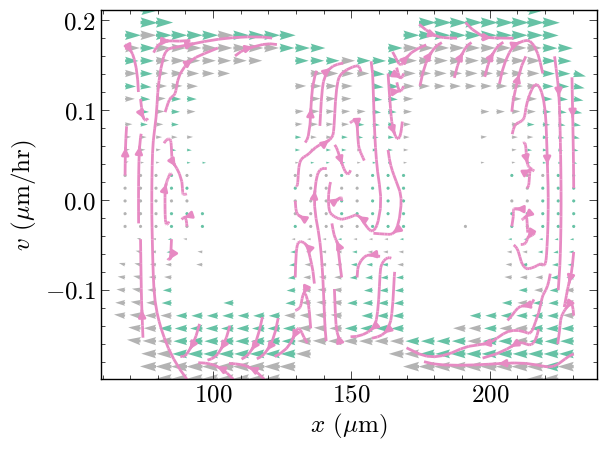

In [88]:
c = plt.get_cmap("Set2")(3)
plt.quiver(X, Y, Y, V, np.where(V>0, 1, 0), cmap="Set2", width=0.007)
plt.streamplot(X, Y, Y, V, linewidth=2, color=c)
plt.xlabel(r"$x$ ($\mu$m)")
plt.ylabel(r"$v$ ($\mu$m/hr)")
plt.show()